# Exploración de Datos - Dataset de Animales

Este notebook analiza dos datasets (`big_size` y `subframes`) con imágenes de animales africanos y sus anotaciones de bounding boxes.

## Objetivos:
- Analizar la distribución de especies en cada dataset
- Comparar estadísticas entre splits (train/val/test)
- Visualizar la distribución de áreas de bounding boxes
- Generar estadísticas descriptivas

In [1]:
# Importar librerías necesarias
import json
import os

import matplotlib.pyplot as plt
import pandas as pd

# Configuración de visualización
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

# Configurar pandas para mostrar todas las columnas
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# cambiar directorio base
os.chdir("..")

## 1. Funciones de Análisis

Definimos las funciones necesarias para cargar y analizar los datos de anotaciones.

In [2]:
def load_json_annotations(json_path):
    """Carga anotaciones desde archivos JSON en formato COCO."""
    with open(json_path) as f:
        data = json.load(f)

    # Convertir a DataFrames
    images_df = pd.DataFrame(data["images"])
    annotations_df = pd.DataFrame(data["annotations"])
    categories_df = pd.DataFrame(data["categories"])

    # Merge para obtener nombres de categorías
    annotations_df = annotations_df.merge(
        categories_df[["id", "name"]], left_on="category_id", right_on="id", suffixes=("", "_cat")
    )

    # Merge para obtener información de imágenes
    annotations_df = annotations_df.merge(
        images_df[["id", "file_name", "width", "height"]],
        left_on="image_id",
        right_on="id",
        suffixes=("", "_img"),
    )

    return annotations_df, images_df, categories_df


def analyze_dataset_split(json_path, dataset_name, split_name):
    """Analiza un split específico de un dataset."""
    annotations_df, images_df, categories_df = load_json_annotations(json_path)

    # Estadísticas básicas
    num_images = len(images_df)
    num_annotations = len(annotations_df)

    # Tamaños únicos de imagen
    unique_sizes = images_df[["width", "height"]].drop_duplicates()
    size_strings = sorted([f"{row['width']}x{row['height']}" for _, row in unique_sizes.iterrows()])

    # Distribución por especie
    species_dist = annotations_df.groupby("name").size().sort_values(ascending=False)

    return {
        "dataset": dataset_name,
        "split": split_name,
        "num_images": num_images,
        "num_annotations": num_annotations,
        "unique_sizes": size_strings,
        "species_distribution": species_dist,  # Ahora es una Series, más simple
        "annotations_df": annotations_df,
    }


def load_all_bbox_data(datasets, splits=None, filter_dataset=None):
    """Carga info detallada de todas las bbox, incluye path completo a la imagen.

    Args:
        datasets: dict con nombre_dataset -> ruta_base
        splits: lista de splits a procesar (default: ["train", "val", "test"])
        filter_dataset: si se especifica, solo procesa este dataset
    """
    splits = splits or ["train", "val", "test"]

    all_bboxes = []
    for dataset_name, base_path in datasets.items():
        # Filtrar por dataset si se especifica
        if filter_dataset and dataset_name != filter_dataset:
            continue

        for split in splits:
            json_path = os.path.join(base_path, f"{split}_{dataset_name}_A_B_E_K_WH_WB.json")
            if not os.path.exists(json_path):
                continue

            with open(json_path) as f:
                data = json.load(f)

            category_map = {cat["id"]: cat["name"] for cat in data["categories"]}
            images_map = {img["id"]: img for img in data["images"]}

            for ann in data["annotations"]:
                bbox = ann["bbox"]
                _, _, w, h = bbox
                if w <= 0 or h <= 0:
                    continue

                img_info = images_map[ann["image_id"]]
                area = w * h
                image_area = img_info["width"] * img_info["height"]
                area_relative = (area / image_area) * 100  # Porcentaje

                all_bboxes.append(
                    {
                        "dataset": dataset_name,
                        "split": split,
                        "image_id": ann["image_id"],
                        "image_name": img_info["file_name"],
                        "category": category_map[ann["category_id"]],
                        "bbox": bbox,
                        "area": area,
                        "area_relative": area_relative,
                        "image_width": img_info["width"],
                        "image_height": img_info["height"],
                    }
                )

    return all_bboxes


def get_top_n_bboxes_in_area_range(bbox_data, area_min, area_max, n=5):
    """Retorna top n bboxes cuya área está entre area_min y area_max.

    Las cajas se ordenan de manera descendente por área.
    """
    filtered = [b for b in bbox_data if area_min <= b["area"] <= area_max]
    filtered.sort(key=lambda x: x["area"], reverse=True)
    return filtered[:n]

## 2. Análisis de Datasets

Cargar y analizar los dos datasets principales: `big_size` y `subframes`.

In [3]:
# Definir rutas de los datasets
datasets = {
    "big_size": "data/groundtruth/json/big_size",
    "subframes": "data/groundtruth/json/sub_frames",
}

# Definir splits
splits = ["train", "val", "test"]

# Almacenar todos los análisis
all_analyses = {}

In [4]:
# Realizar análisis para todos los datasets y splits
for dataset_name, dataset_path in datasets.items():
    print(f"Validando dataset: {dataset_name}")
    all_analyses[dataset_name] = {}

    for split in splits:
        json_file = f"{dataset_path}/{split}_{dataset_name}_A_B_E_K_WH_WB.json"
        if os.path.exists(json_file):
            print(f"  Cargando {split}...")
            analysis = analyze_dataset_split(json_file, dataset_name, split)
            all_analyses[dataset_name][split] = analysis
        else:
            print(f"  Archivo no encontrado: {json_file}")

Validando dataset: big_size
  Cargando train...
  Cargando val...
  Cargando test...
Validando dataset: subframes
  Cargando train...
  Cargando val...
  Cargando test...


## 3. Estadísticas por Dataset y Split

Mostraremos las estadísticas detalladas para cada dataset y split.

In [5]:
# Mostrar estadísticas detalladas para cada dataset usando DataFrames
for dataset_name, dataset_analyses in all_analyses.items():
    print(f"{'=' * 60}")
    print(f"DATASET: {dataset_name.upper()}")
    print(f"{'=' * 60}")

    # Crear tabla resumen para el dataset
    dataset_summary = []
    species_data_by_split = {}

    for split_name, analysis in dataset_analyses.items():
        dataset_summary.append(
            {
                "Split": split_name,
                "Imágenes": f"{analysis['num_images']:,}",
                "Anotaciones": f"{analysis['num_annotations']:,}",
                "Tamaños únicos": ", ".join(analysis["unique_sizes"]),
            }
        )

        # Recolectar datos de especies por split (ahora species_distribution es Series)
        species_data_by_split[split_name] = analysis["species_distribution"]

    # Mostrar tabla resumen del dataset
    summary_df = pd.DataFrame(dataset_summary)
    print(f"\n### Resumen General - {dataset_name}")
    display(summary_df)

    # Crear tabla consolidada de distribución por especies
    if species_data_by_split:
        species_df = pd.DataFrame(species_data_by_split).fillna(0).astype(int)
        species_df["Total"] = species_df.sum(axis=1)
        species_df = species_df.sort_values("Total", ascending=False)

        print(f"\n### Distribución de Anotaciones por Especie - {dataset_name}")
        display(species_df)

    print("\n" + "─" * 60 + "\n")

DATASET: BIG_SIZE

### Resumen General - big_size


,Split,Imágenes,Anotaciones,Tamaños únicos
0,train,928,"6,962","5472x3648, 5496x3670, 5521x3687, 5525x3690, 6000x4000"
1,val,111,978,"5472x3648, 5496x3670, 5521x3687, 5525x3690, 6000x4000"
2,test,258,"2,299","5472x3648, 5496x3670, 5525x3690, 6000x4000"



### Distribución de Anotaciones por Especie - big_size


,train,val,test,Total
name,,,,
Elephant,2012,264,688,2964
Alcelaphinae,1678,369,675,2722
Kob,1732,161,477,2370
Buffalo,1058,102,349,1509
Warthog,316,43,74,433
Waterbuck,166,39,36,241



────────────────────────────────────────────────────────────

DATASET: SUBFRAMES

### Resumen General - subframes


,Split,Imágenes,Anotaciones,Tamaños únicos
0,train,"1,724","7,461",2000x2000
1,val,666,994,"1472x1648, 1472x2000, 1496x1670, 1496x2000, 1521x1687, 1521x2000, 1525x1690, 1525x2000, 2000x1648, 2000x1670, 2000x1687, 2000x1690, 2000x2000"
2,test,"1,548","2,326","1472x1648, 1472x2000, 1496x1670, 1496x2000, 1525x1690, 1525x2000, 2000x1648, 2000x1670, 2000x1690, 2000x2000"



### Distribución de Anotaciones por Especie - subframes


,train,val,test,Total
name,,,,
Elephant,2443,267,696,3406
Alcelaphinae,1701,376,681,2758
Kob,1745,163,482,2390
Buffalo,1080,104,356,1540
Warthog,323,44,75,442
Waterbuck,169,40,36,245



────────────────────────────────────────────────────────────



## 4. Visualización de Distribución de Especies

Distribución de especies en ambos datasets.

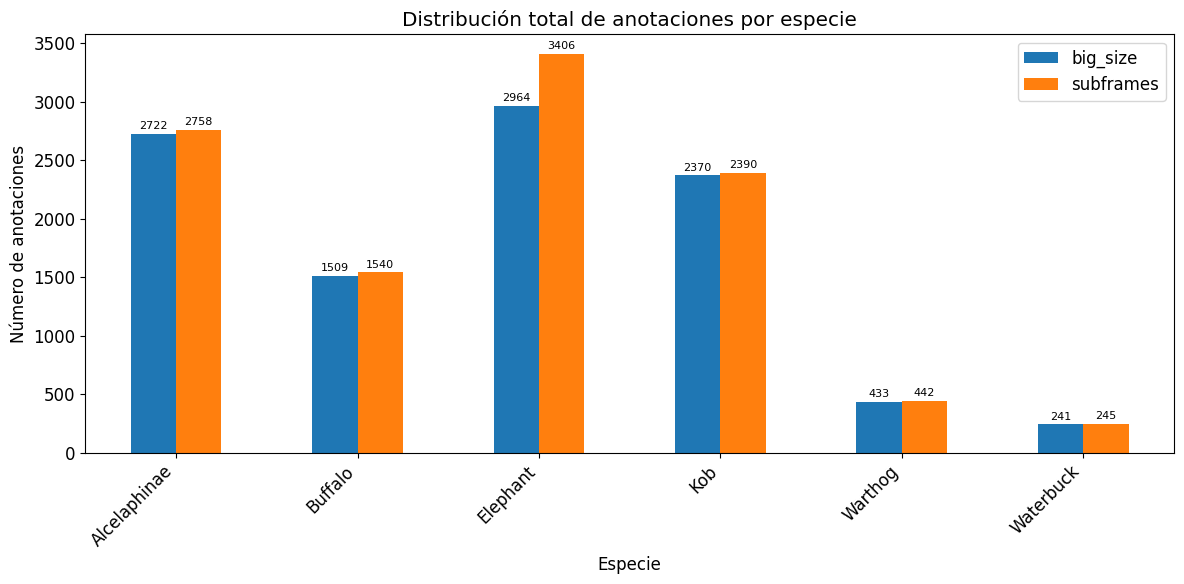

In [6]:
all_species_set = set()
dataset_species_data = {}

for dataset_name, dataset_analyses in all_analyses.items():
    # Combinar datos de todos los splits para el dataset
    all_species = {}

    for analysis in dataset_analyses.values():
        # Ahora species_distribution es una Series, iteramos sobre index y values
        for species_name, count in analysis["species_distribution"].items():
            if species_name in all_species:
                all_species[species_name] += count
            else:
                all_species[species_name] = count

    dataset_species_data[dataset_name] = all_species
    all_species_set.update(all_species.keys())

# Ordenar especies alfabéticamente
sorted_species = sorted(all_species_set)

# Crear DataFrame similar a utils.py
df_data = {}
for dataset_name, species_counts in dataset_species_data.items():
    df_data[dataset_name] = [species_counts.get(species, 0) for species in sorted_species]

df = pd.DataFrame(df_data, index=sorted_species)


ax = df.plot(kind="bar", figsize=(12, 6))
plt.title("Distribución total de anotaciones por especie")
plt.ylabel("Número de anotaciones")
plt.xlabel("Especie")
plt.xticks(rotation=45, ha="right")

# Agregar etiquetas en las barras
for container in ax.containers:
    ax.bar_label(container, fontsize=8, padding=2)

plt.tight_layout()
plt.show()

## 5. Análisis de Áreas de Bounding Boxes

Distribución de áreas de bounding boxes y estadísticas descriptivas, del conjunto subframes

In [7]:
print("ANÁLISIS DE ÁREAS DE BOUNDING BOXES")
print("=" * 50)

# Usar la función factorizada para cargar datos de bboxes (solo subframes)
all_bbox_data = load_all_bbox_data(datasets, filter_dataset="subframes")
bbox_df = pd.DataFrame(all_bbox_data)

print(f"\n### Estadísticas de Áreas Absolutas (px²) - Dataset: {bbox_df['dataset'].iloc[0]}")
stats_absolute = bbox_df.groupby("category")["area"].describe().round(2)
display(stats_absolute)

print("\n### Estadísticas de Áreas Relativas (% de imagen)")
stats_relative_global = bbox_df.groupby("category")["area_relative"].describe().round(4)
display(stats_relative_global)

print("\n### Estadísticas de Áreas Relativas por Split (% de imagen)")
stats_relative_split = bbox_df.groupby(["split", "category"])["area_relative"].describe().round(4)

for split in ["train", "val", "test"]:
    subset = stats_relative_split.xs(split, level="split", drop_level=False)
    if not subset.empty:
        display(subset)

print("\n### Distribución de Tamaños de Imagen por Split")
image_sizes = (
    bbox_df.groupby(["split", "image_width", "image_height"]).size().reset_index(name="count")
)

for split in ["train", "val", "test"]:
    subset = image_sizes[image_sizes["split"] == split]
    if not subset.empty:
        subset_sorted = subset.sort_values("count", ascending=False)
        display(subset_sorted)

ANÁLISIS DE ÁREAS DE BOUNDING BOXES

### Estadísticas de Áreas Absolutas (px²) - Dataset: subframes

### Estadísticas de Áreas Absolutas (px²) - Dataset: subframes


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Alcelaphinae,2758.0,2348.86,1067.16,230.0,1558.0,2240.0,2964.00,7560.0
Buffalo,1540.0,4305.40,1946.86,420.0,2886.0,4097.5,5472.00,12573.0
Elephant,3406.0,1688.60,1315.51,72.0,731.0,1308.0,2304.00,12648.0
Kob,2390.0,1836.06,703.79,280.0,1350.0,1750.0,2235.25,7300.0
Warthog,442.0,1199.87,633.79,187.0,685.0,1137.0,1584.50,4536.0
Waterbuck,245.0,2809.03,1134.87,816.0,2091.0,2684.0,3304.00,8393.0



### Estadísticas de Áreas Relativas (% de imagen)


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Alcelaphinae,2758.0,0.0587,0.0267,0.0058,0.0390,0.0560,0.0741,0.1890
Buffalo,1540.0,0.1076,0.0487,0.0105,0.0722,0.1024,0.1368,0.3143
Elephant,3406.0,0.0450,0.0359,0.0018,0.0192,0.0348,0.0619,0.3162
Kob,2390.0,0.0459,0.0176,0.0070,0.0338,0.0438,0.0559,0.1825
Warthog,442.0,0.0300,0.0158,0.0047,0.0171,0.0284,0.0396,0.1134
Waterbuck,245.0,0.0702,0.0284,0.0204,0.0523,0.0671,0.0826,0.2098



### Estadísticas de Áreas Relativas por Split (% de imagen)


count    mean     std     min     25%     50%     75%  \
split category                                                               
train Alcelaphinae  1701.0  0.0653  0.0274  0.0058  0.0444  0.0624  0.0820   
      Buffalo       1080.0  0.1173  0.0508  0.0122  0.0790  0.1140  0.1494   
      Elephant      2443.0  0.0427  0.0338  0.0018  0.0178  0.0326  0.0598   
      Kob           1745.0  0.0476  0.0180  0.0094  0.0352  0.0459  0.0576   
      Warthog        323.0  0.0323  0.0161  0.0056  0.0201  0.0306  0.0422   
      Waterbuck      169.0  0.0737  0.0285  0.0204  0.0567  0.0697  0.0866   

                       max  
split category              
train Alcelaphinae  0.1890  
      Buffalo       0.3143  
      Elephant      0.3162  
      Kob           0.1825  
      Warthog       0.1134  
      Waterbuck     0.2098

count    mean     std     min     25%     50%     75%  \
split category                                                              
val   Alcelaphinae  376.0  0.0529  0.0202  0.0107  0.0379  0.0522  0.0651   
      Buffalo       104.0  0.0991  0.0364  0.0235  0.0751  0.0996  0.1225   
      Elephant      267.0  0.0476  0.0336  0.0041  0.0247  0.0379  0.0620   
      Kob           163.0  0.0424  0.0159  0.0092  0.0316  0.0419  0.0530   
      Warthog        44.0  0.0268  0.0139  0.0069  0.0126  0.0293  0.0377   
      Waterbuck      40.0  0.0634  0.0277  0.0253  0.0399  0.0640  0.0805   

                       max  
split category              
val   Alcelaphinae  0.1297  
      Buffalo       0.1906  
      Elephant      0.2016  
      Kob           0.1047  
      Warthog       0.0516  
      Waterbuck     0.1278

count    mean     std     min     25%     50%     75%  \
split category                                                              
test  Alcelaphinae  681.0  0.0454  0.0217  0.0094  0.0282  0.0429  0.0588   
      Buffalo       356.0  0.0807  0.0319  0.0105  0.0569  0.0786  0.1010   
      Elephant      696.0  0.0517  0.0425  0.0030  0.0210  0.0393  0.0682   
      Kob           482.0  0.0408  0.0154  0.0070  0.0297  0.0380  0.0492   
      Warthog        75.0  0.0217  0.0127  0.0047  0.0106  0.0187  0.0304   
      Waterbuck      36.0  0.0616  0.0261  0.0264  0.0416  0.0576  0.0710   

                       max  
split category              
test  Alcelaphinae  0.1350  
      Buffalo       0.2074  
      Elephant      0.2695  
      Kob           0.1001  
      Warthog       0.0559  
      Waterbuck     0.1428


### Distribución de Tamaños de Imagen por Split


,split,image_width,image_height,count
10,train,2000,2000,7461


,split,image_width,image_height,count
20,val,2000,2000,829
16,val,2000,1648,102
11,val,1472,1648,24
12,val,1472,2000,20
17,val,2000,1670,11
19,val,2000,1690,4
15,val,1525,2000,1
14,val,1525,1690,1
13,val,1496,2000,1
18,val,2000,1687,1


,split,image_width,image_height,count
9,test,2000,2000,1845
6,test,2000,1648,130
1,test,1472,2000,105
0,test,1472,1648,78
7,test,2000,1670,77
8,test,2000,1690,41
2,test,1496,1670,31
3,test,1496,2000,16
4,test,1525,1690,2
5,test,1525,2000,1


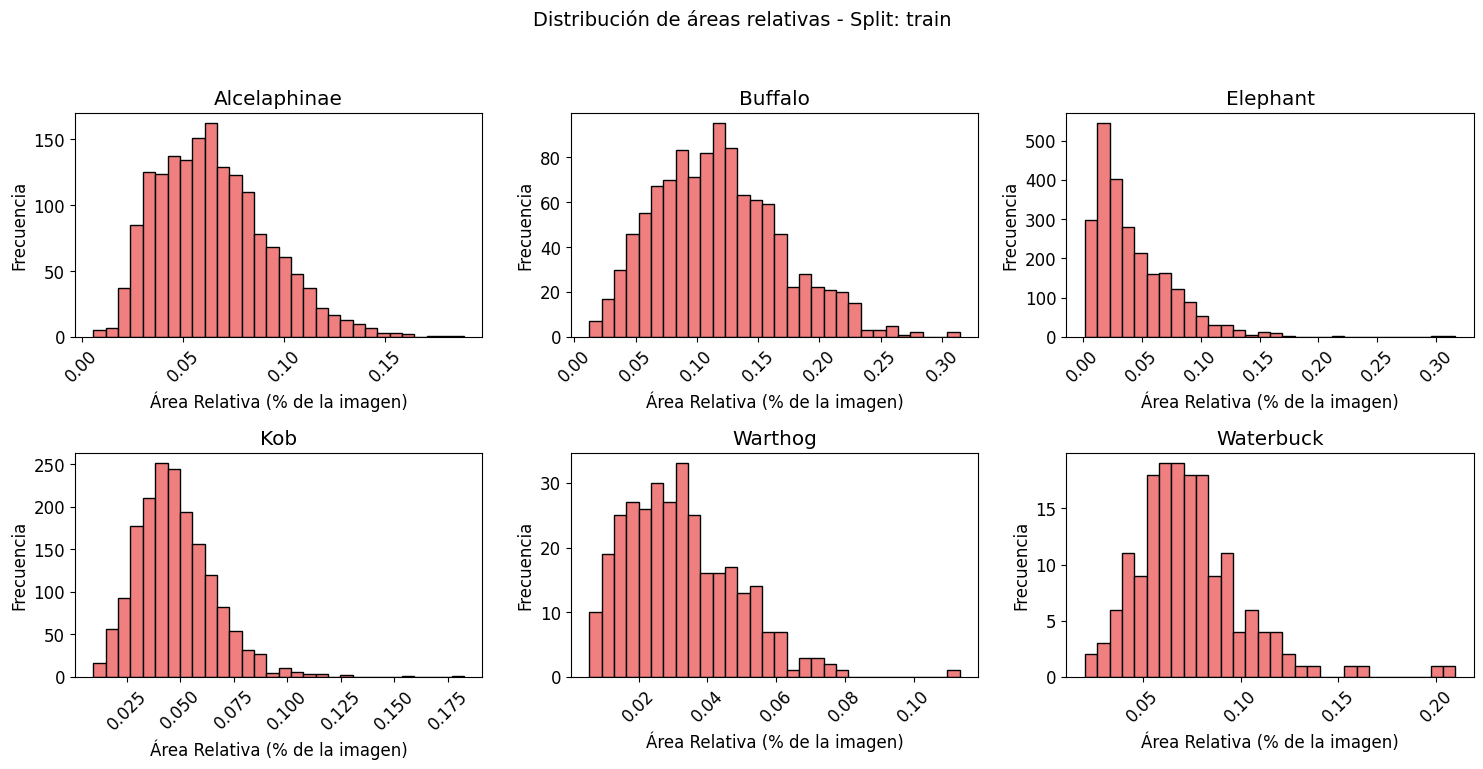

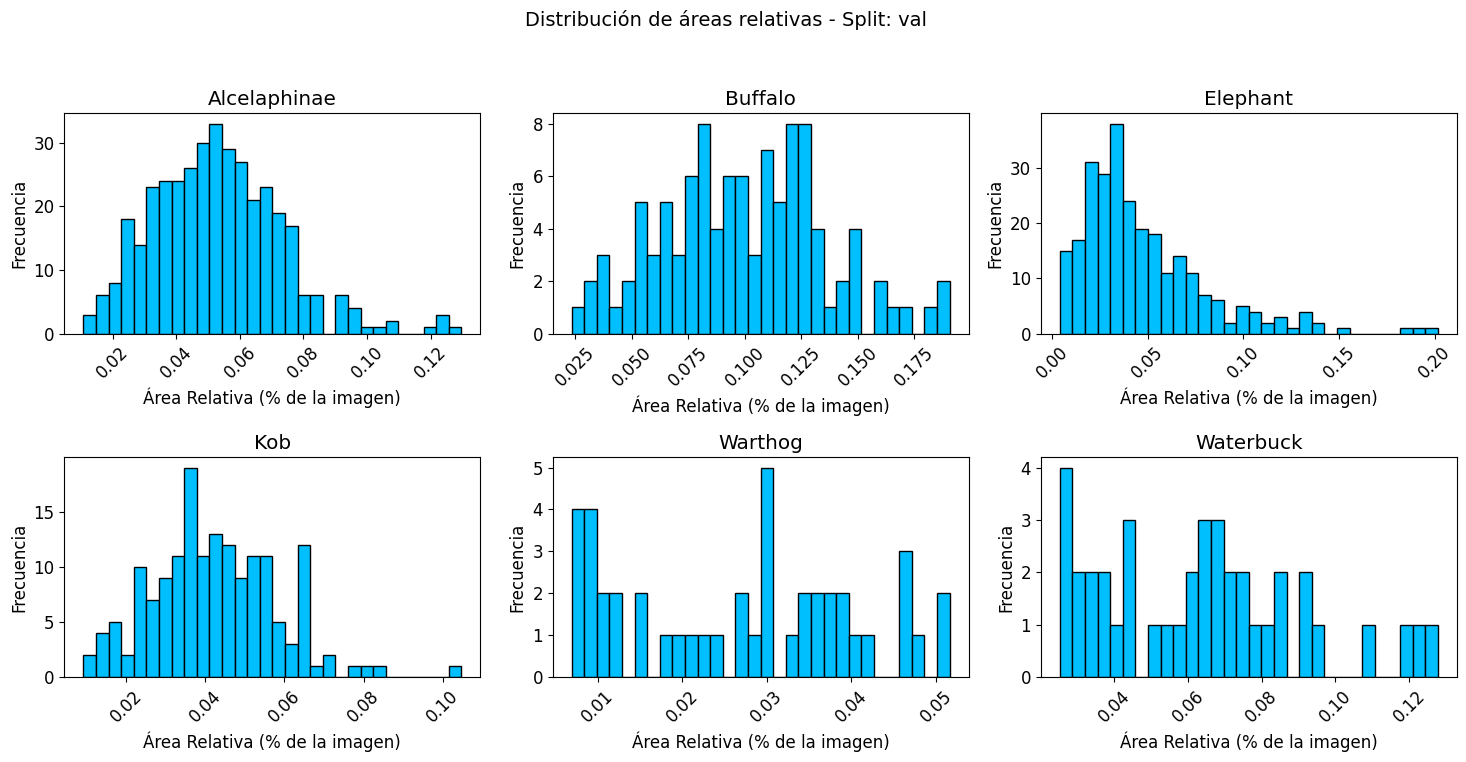

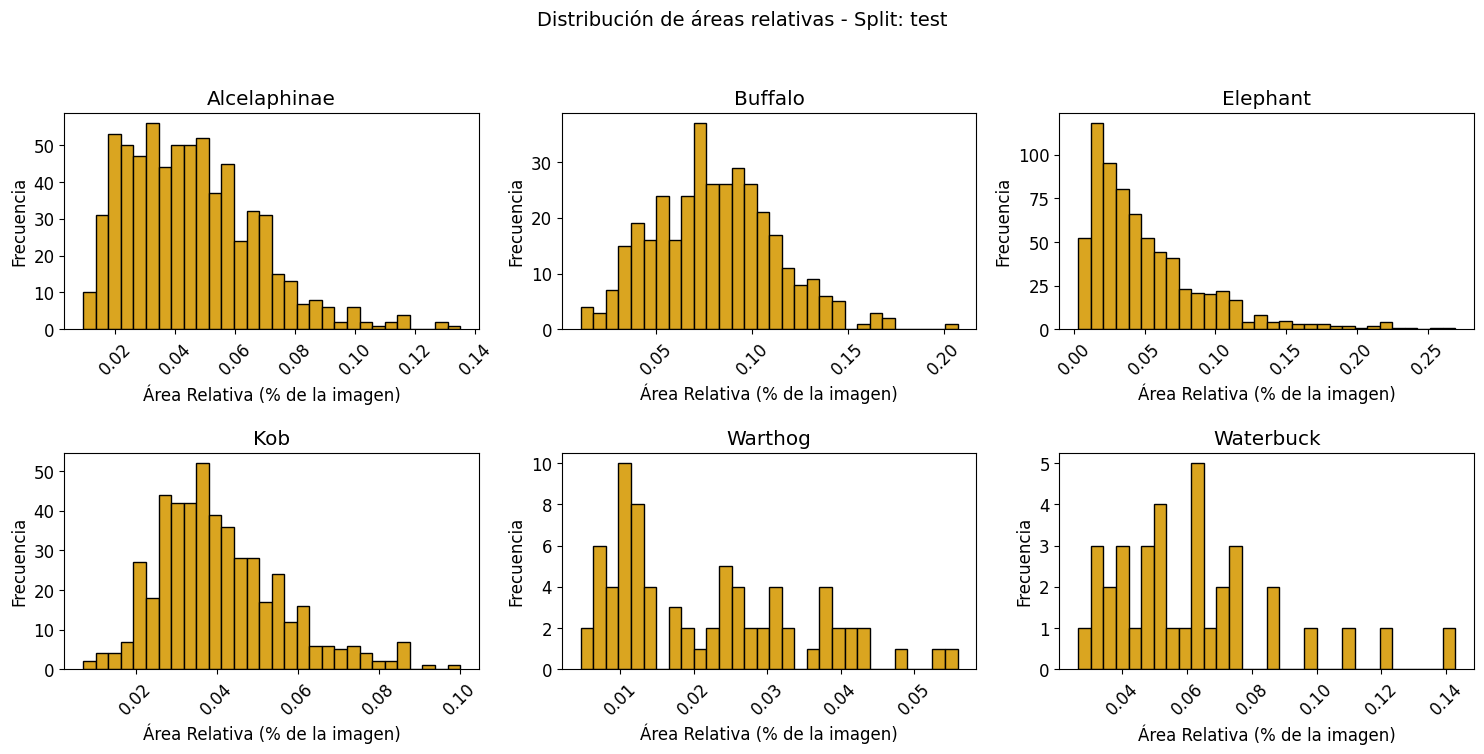

In [8]:
splits = bbox_df["split"].unique()

split_colors = {
    "train": "lightcoral",
    "val": "deepskyblue",
    "test": "goldenrod",
}

for split in splits:
    df_split = bbox_df[bbox_df["split"] == split]
    all_areas = {}

    # Agrupar áreas relativas por categoría
    for _, row in df_split.iterrows():
        category = row["category"]
        area_relative = row["area_relative"]
        if category not in all_areas:
            all_areas[category] = []
        all_areas[category].append(area_relative)

    # Configurar subplots
    sorted_classes = sorted(all_areas.keys())
    n_classes = len(sorted_classes)
    n_cols = 3
    n_rows = (n_classes + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    color = split_colors.get(split, "gray")

    # Crear histograma para cada clase
    for idx, class_name in enumerate(sorted_classes):
        ax = axes[idx]
        ax.hist(all_areas[class_name], bins=30, color=color, edgecolor="black")
        ax.set_title(f"{class_name}")
        ax.set_xlabel("Área Relativa (% de la imagen)")
        ax.set_ylabel("Frecuencia")
        ax.tick_params(axis="x", labelrotation=45)

    # Eliminar subplots vacíos
    for j in range(len(sorted_classes), len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f"Distribución de áreas relativas - Split: {split}", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [9]:
# Top BBoxes en Rango Específico de Área (replicando get_top_n_bboxes_in_area_range)
print("## Top BBoxes en Rango Específico de Área")
print("=" * 50)

# Definir parámetros de búsqueda
area_min = 1000
area_max = 13000
n = 5

# Usar las funciones factorizadas
all_bbox_data_complete = load_all_bbox_data(datasets, filter_dataset="subframes")
top_bboxes = get_top_n_bboxes_in_area_range(all_bbox_data_complete, area_min, area_max, n)

print(f"\nTop {n} bounding boxes con área entre {area_min} y {area_max} px²:")
print("(Ordenados por área descendente)\n")

# Crear DataFrame para mostrar como tabla
if len(top_bboxes) > 0:
    top_df = pd.DataFrame(top_bboxes)

    # Seleccionar columnas específicas para coincidir con el markdown
    columns_to_show = [
        "dataset",
        "split",
        "category",
        "area",
        "area_relative",
        "image_name",
        "bbox",
    ]
    display_df = top_df[columns_to_show].copy()

    # Convertir area_relative de porcentaje a decimal para coincidir con el formato del markdown
    display_df["area_relative"] = (display_df["area_relative"] / 100).round(6)

    print("Resultados:")
    display(display_df)

else:
    print("No se encontraron bounding boxes en el rango especificado.")

## Top BBoxes en Rango Específico de Área

Top 5 bounding boxes con área entre 1000 y 13000 px²:
(Ordenados por área descendente)

Resultados:


,dataset,split,category,area,area_relative,image_name,bbox
0,subframes,train,Elephant,12648,0.003162,1ef71a1e01dce600fa82188b25b560a6c5acf780_S0.JPG,"[790, 799, 102, 124]"
1,subframes,train,Buffalo,12573,0.003143,L_09_05_16_DSC09691_S2.JPG,"[1161, 538, 127, 99]"
2,subframes,train,Elephant,12496,0.003124,03681f46c5f946b4272e7637a5998ce5ca1630a5_S0.JPG,"[1534, 143, 142, 88]"
3,subframes,train,Buffalo,12250,0.003062,L_09_05_16_DSC09692_S5.JPG,"[1178, 1185, 125, 98]"
4,subframes,train,Elephant,11970,0.002993,1e09abc042436630c66e62166d02b9b15e83b2d0_S2.JPG,"[1647, 1000, 133, 90]"
